## Destagger Vertical ##

In [42]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

In [14]:
# make land versions of cmaps, land is grey
cm_vel = copy.copy(cm.curl)
cm_vel.set_bad('grey')

In [47]:
def get_uw(dir, it, x_slice, yvalue):
    # read in both the u and v velocity components
    base_u = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_U.nc')
    base_w = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_W.nc')

# the u velocity is staggered in the x direction, unstagger it
    u_region = viz_tools.unstagger_xarray(
        base_u.vozocrtx.isel(time_counter=it, y=yvalue, x=x_slice), 'x')

# the w velocity is staggered in the z direction, unstagger it
    w_region = viz_tools.unstagger_xarray(
        base_w.vovecrtz.isel(time_counter=it, y=yvalue, x=x_slice), 'depthw')
    w_region['depthw'] = u_region.depthu.values
    w_region.rename({'depthw': 'depthu'})
    
# merge u and w into one dataset, dropping the now inaccurate nav_lon and nav_lat varaiables
    base_uw = xr.merge([u_region.rename({'depthu': 'deptht'}).drop(['nav_lon', 'nav_lat']), 
                    w_region.rename({'depthw': 'deptht'}).drop(['nav_lon', 'nav_lat'])])

# give x and y there own coordinate names
    base_uw = base_uw.assign(grid_X=lambda alpha: alpha.x)

    return base_u.vozocrtx.isel(time_counter=it, y=yvalue, x=x_slice), base_w.vovecrtz.isel(time_counter=it, y=yvalue, x=x_slice), u_region, w_region, base_uw


In [83]:
iz = 30  # width of domain plotted
y_slice=slice(400+iz, 500-iz)
x_slice=slice(250+iz, 350-iz)
u_staggered, w_staggered, u_region, w_region, base_uw = get_uw('base_again', 23, x_slice, 446)

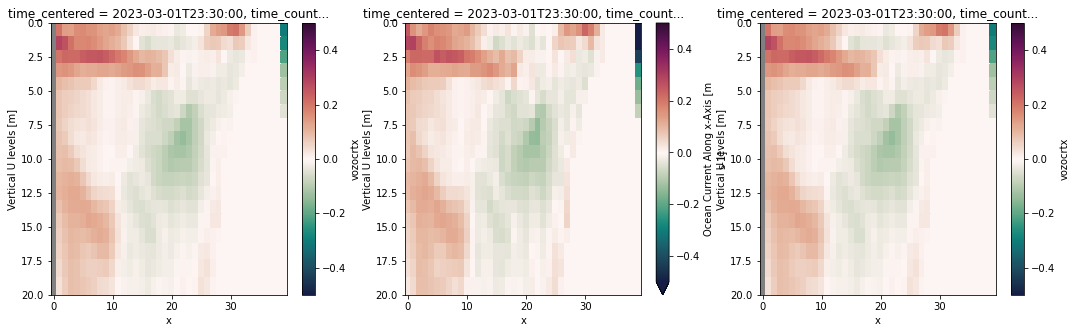

In [84]:
# checking u velocity
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
u_region.plot(ax=axs[0], cmap=cm_vel, yincrease=False, vmax=0.5, vmin=-0.5)
u_staggered.plot(ax=axs[1], cmap=cm_vel, yincrease=False, vmax=0.5, vmin=-0.5)
base_uw.vozocrtx.plot(ax=axs[2], cmap=cm_vel, yincrease=False, vmax=0.5, vmin=-0.5)
for ax in axs:
    ax.set_ylim(20, 0)

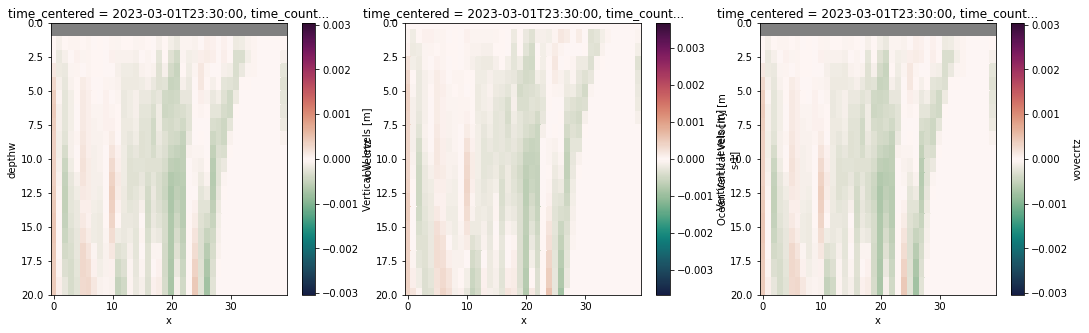

In [85]:
# checking w velocity
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
w_region.plot(ax=axs[0], cmap=cm_vel, yincrease=False)
w_staggered.plot(ax=axs[1], cmap=cm_vel, yincrease=False)
base_uw.vovecrtz.plot(ax=axs[2], cmap=cm_vel, yincrease=False)
for ax in axs:
    ax.set_ylim(20, 0)

(200.0, 0.0)

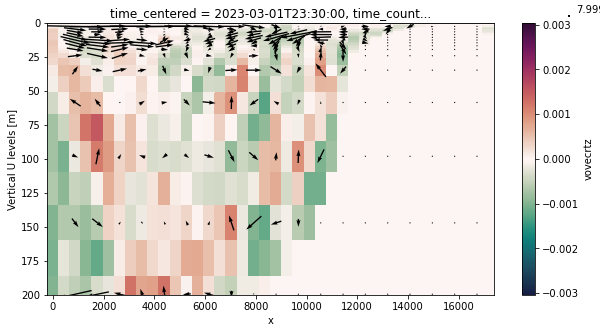

In [98]:
step = 2
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
base_uw['x'] = base_uw.grid_X * 440
base_uw.vovecrtz.plot(ax=ax, cmap=cm_vel)
# need to invert w as we plot z increasing downward
base_uw['w_inverse'] = -base_uw.vovecrtz
(base_uw
     .isel(x=slice(None, None, step), deptht=slice(None, None,step))
     .plot.quiver(x='x', y='deptht', u='vozocrtx', v='w_inverse', 
                        pivot='mid', angles='xy', scale_units='xy', scale=0.0001, ax=ax))
ax.set_ylim(200, 0)

In [87]:
base_uw

<xarray.Dataset>
Dimensions:        (deptht: 40, x: 40)
Coordinates:
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  datetime64[ns] 2023-03-01T23:30:00
    time_counter   datetime64[ns] 2023-03-01T23:30:00
  * x              (x) int64 0 440 880 1320 1760 ... 15840 16280 16720 17160
Data variables:
    vozocrtx       (deptht, x) float32 nan 0.2037 0.139 0.136 ... 0.0 0.0 0.0
    vovecrtz       (deptht, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    grid_X         (x) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39